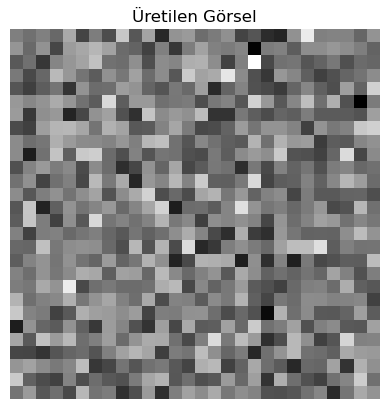

Discriminator çıktısı: 0.48932361602783203


In [39]:
import torch
import matplotlib.pyplot as plt

# Modelleri oluştur
generator = Generator()
discriminator = Discriminator()

# Rastgele gürültü vektörü (latent input)
z = torch.randn(1, 100)

# Görsel üret (generator)
fake_image = generator(z)
fake_image_detached = fake_image.detach().squeeze()

# Görseli çiz (-1,1 → 0,1 normalize)
plt.imshow((fake_image_detached + 1) / 2.0, cmap='gray')
plt.title("Üretilen Görsel")
plt.axis("off")
plt.show()




# Discriminator çıktısı
discriminator.eval()  
output = discriminator(fake_image)
print("Discriminator çıktısı:", output.item())


Epoch 1 - D Loss: 0.0264  G Loss: 7.3503
Epoch 2 - D Loss: 0.0042  G Loss: 10.8080
Epoch 3 - D Loss: 0.0012  G Loss: 11.9646
Epoch 4 - D Loss: 0.0002  G Loss: 12.5734
Epoch 5 - D Loss: 0.0005  G Loss: 13.6092
Epoch 6 - D Loss: 0.0001  G Loss: 14.9081
Epoch 7 - D Loss: 0.0199  G Loss: 15.5824
Epoch 8 - D Loss: 0.0031  G Loss: 16.2155
Epoch 9 - D Loss: 0.0001  G Loss: 16.1063
Epoch 10 - D Loss: 0.0001  G Loss: 16.7055
Epoch 11 - D Loss: 0.0000  G Loss: 17.0874
Epoch 12 - D Loss: 0.0120  G Loss: 18.0052
Epoch 13 - D Loss: 0.0002  G Loss: 19.9389
Epoch 14 - D Loss: 0.0001  G Loss: 20.3127
Epoch 15 - D Loss: 0.0000  G Loss: 19.3744
Epoch 16 - D Loss: 0.0224  G Loss: 16.7666
Epoch 17 - D Loss: 0.0000  G Loss: 18.3855
Epoch 18 - D Loss: 0.0000  G Loss: 19.0228
Epoch 19 - D Loss: 0.0000  G Loss: 18.0894
Epoch 20 - D Loss: 0.0004  G Loss: 18.0859
Epoch 21 - D Loss: 0.0001  G Loss: 17.9352
Epoch 22 - D Loss: 0.0001  G Loss: 16.9153
Epoch 23 - D Loss: 0.0000  G Loss: 20.5978
Epoch 24 - D Loss: 0.

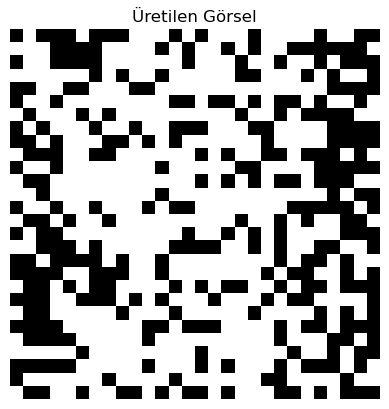

Discriminator çıktısı: 0.0000


In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# --- Generator Sınıfı ---
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1, 28, 28)


# --- Discriminator Sınıfı ---
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


# --- Veri Hazırlama ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model Oluşturma ---
G = Generator().to(device)
D = Discriminator().to(device)

# --- Kayıp Fonksiyonu ve Optimizatörler ---
loss_fn = nn.BCELoss()
optim_G = optim.Adam(G.parameters(), lr=0.0002)
optim_D = optim.Adam(D.parameters(), lr=0.0002)

# --- Sabit Gürültü (örnek üretim için) ---
fixed_noise = torch.randn(16, 100).to(device)

# --- Görüntü Kaydetme Fonksiyonu ---
def save_images(images, epoch):
    os.makedirs("generated_fake_imgs", exist_ok=True)
    grid = utils.make_grid(images, nrow=4, normalize=True)
    npimg = grid.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.axis("off")
    plt.savefig(f"generated_fake_imgs/epoch_{epoch+1}.png")
    plt.close()

# --- Eğitim Döngüsü ---
epochs = 50

for epoch in range(epochs):
    for real, _ in dataloader:
        real = real.to(device)
        batch_size = real.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # --- Discriminator Eğitimi ---
        noise = torch.randn(batch_size, 100).to(device)
        fake_images = G(noise)

        D_real = D(real)
        D_fake = D(fake_images.detach())

        D_loss = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)

        optim_D.zero_grad()
        D_loss.backward()
        optim_D.step()

        # --- Generator Eğitimi ---
        output = D(fake_images)
        G_loss = loss_fn(output, real_labels)

        optim_G.zero_grad()
        G_loss.backward()
        optim_G.step()

    # Epoch sonunda örnek görselleri kaydet
    with torch.no_grad():
        fake = G(fixed_noise)
        save_images(fake, epoch)

    print(f"Epoch {epoch+1} - D Loss: {D_loss.item():.4f}  G Loss: {G_loss.item():.4f}")

# --- Eğitim Sonrası Görselleştirme ---
with torch.no_grad():
    z = torch.randn(1, 100).to(device)
    fake_image = G(z)  
    fake_image_cpu = fake_image.cpu().squeeze()  

plt.imshow((fake_image_cpu + 1) / 2.0, cmap='gray')
plt.title("Üretilen Görsel")
plt.axis("off")
plt.show()

# --- Discriminator Test ---
D.eval()
with torch.no_grad():
    output = D(fake_image)  
print(f"Discriminator çıktısı: {output.item():.4f}")
